# Pré-processamento

## Carregando dataset sintético

In [1]:
import pandas as pd

# Ler o CSV
df = pd.read_csv("emails_sinteticos.csv", sep=";")

# Verificar
print(df.head())

                                               email    categoria
0  Bom dia, poderiam me enviar o relatório atuali...    Produtivo
1  Oi pessoal, tudo certo por aí? Só passando par...  Improdutivo
2  Prezados, segue em anexo a planilha com os dad...    Produtivo
3  Gostaria de saber se já temos uma previsão par...    Produtivo
4  Parabéns a todos pelo excelente resultado trim...  Improdutivo


## Usando spacy para lematização, remoção de stopwords e pontuações.

In [2]:
import spacy

nlp = spacy.load("pt_core_news_sm")

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ 
        for token in doc 
        if not token.is_stop and not token.is_punct
    ]
    return " ".join(tokens)

df["email_clean"] = df["email"].apply(preprocess)

print(df.head())

                                               email    categoria  \
0  Bom dia, poderiam me enviar o relatório atuali...    Produtivo   
1  Oi pessoal, tudo certo por aí? Só passando par...  Improdutivo   
2  Prezados, segue em anexo a planilha com os dad...    Produtivo   
3  Gostaria de saber se já temos uma previsão par...    Produtivo   
4  Parabéns a todos pelo excelente resultado trim...  Improdutivo   

                                         email_clean  
0  dia poder enviar relatório atualizar carteira ...  
1                        oi pessoal certo passar alô  
2      prezar seguir anexo planilha dado conferência  
3                  gostar previsão liberação crédito  
4            parabéns excelente resultado trimestral  


## Aplicação de labels 0 e 1, remoção de duplicatas

In [3]:
df["categoria"] = df["categoria"].astype(str).str.strip().str.lower()

In [4]:
df["label"] = df["categoria"].map({"produtivo": 1, "improdutivo": 0})

In [5]:
print(df["label"].isna().sum())

0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   email        1148 non-null   object
 1   categoria    1148 non-null   object
 2   email_clean  1148 non-null   object
 3   label        1148 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 36.0+ KB


In [7]:
print(df["categoria"].value_counts())

categoria
produtivo      574
improdutivo    574
Name: count, dtype: int64


In [8]:
df = df.drop_duplicates(subset=["email_clean"])

In [9]:
print(df["categoria"].value_counts())

categoria
produtivo      573
improdutivo    567
Name: count, dtype: int64


In [10]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
df.head()

,email,categoria,email_clean,label
0,"Bom dia, o sistema de folha de pagamento está ...",produtivo,dia folha pagamento atraso resolver,1
1,Bom dia. Tenho uma dúvida sobre a nova sistemá...,produtivo,dia dúvida sistemática provisionamento devedor...,1
2,"Prezado time, o sistema de backup será atualiz...",produtivo,prezar time backup ser atualizar hoje noite,1
3,Favor emitir nota fiscal de serviço prestado n...,produtivo,emitir nota fiscal serviço prestar dia 10/05 c...,1
4,"Por favor, confirmar inclusão dos novos benefi...",produtivo,confirmar inclusão beneficiário apólice,1


# Treinamento

## Split treino/teste

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["email_clean"], df["label"], test_size=0.2, random_state=42
)

## Vetorização TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Treinamento de modelo de Regressão Logística

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression()
clf.fit(X_train_vec, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Prevendo subset de teste e avaliando métricas de desempenho

In [16]:
y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       110
           1       0.95      0.97      0.96       118

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228



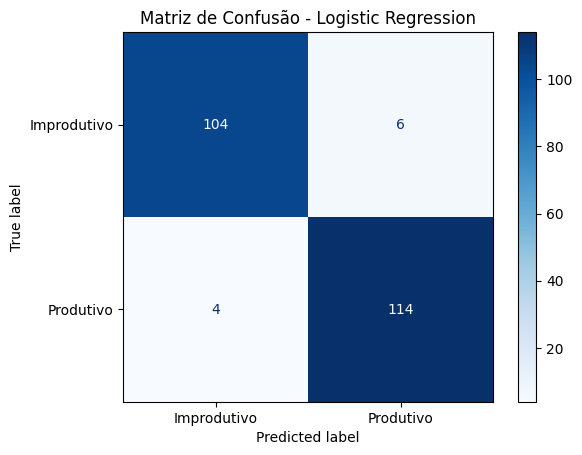

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# calcula a matriz
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# exibe a matriz com rótulos
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Improdutivo", "Produtivo"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusão - Logistic Regression")
plt.show()


In [21]:
email_novo = preprocess("Prezados, Gostaria de propor uma reunião para discutirmos os próximos passos do Projeto Alpha. Minhas disponibilidades para a próxima semana são: Segunda-feira, 07/07, às 10h Quarta-feira, 09/07, às 14h Por favor, informem qual data e horário se encaixam melhor para vocês. Obrigado, Ana Paula")
email_vec = vectorizer.transform([email_novo])
pred = clf.predict(email_vec)[0]
pred

np.int64(1)

# Salvando o modelo e o Vectorizer

In [22]:
import joblib

# salva o classificador treinado
joblib.dump(clf, "modelo_produtivo.joblib")

# salva o vetorizar treinado
joblib.dump(vectorizer, "vectorizer.joblib")

['vectorizer.joblib']